In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import psycopg2
import pandas as pd
import polars as pl
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT"))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DATA_FOLDER = os.getenv("DATA_FOLDER")

In [3]:
bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

In [4]:
if "events.csv" not in os.listdir(DATA_FOLDER):
    with bigbrotr.cursor() as cur:
        with open(os.path.join(DATA_FOLDER, 'events.csv'), 'w') as f:
            # Usa COPY per esportare i dati in CSV
            cur.copy_expert("COPY (SELECT id, pubkey, created_at, kind FROM events) TO STDOUT WITH CSV HEADER", f)
events = pl.read_csv(os.path.join(DATA_FOLDER, 'events.csv'))

In [5]:
kind_counts = events.select(
    pl.col("kind").value_counts()
)
kind_counts = pd.DataFrame(kind_counts.to_pandas())
kind_counts['count'] = kind_counts['kind'].apply(lambda x: x['count'])
kind_counts['kind'] = kind_counts['kind'].apply(lambda x: x['kind'])
kind_counts = kind_counts.sort_values('count', ascending=False).reset_index(drop=True)
kind_counts['perc'] = kind_counts['count'] / kind_counts['count'].sum() * 100

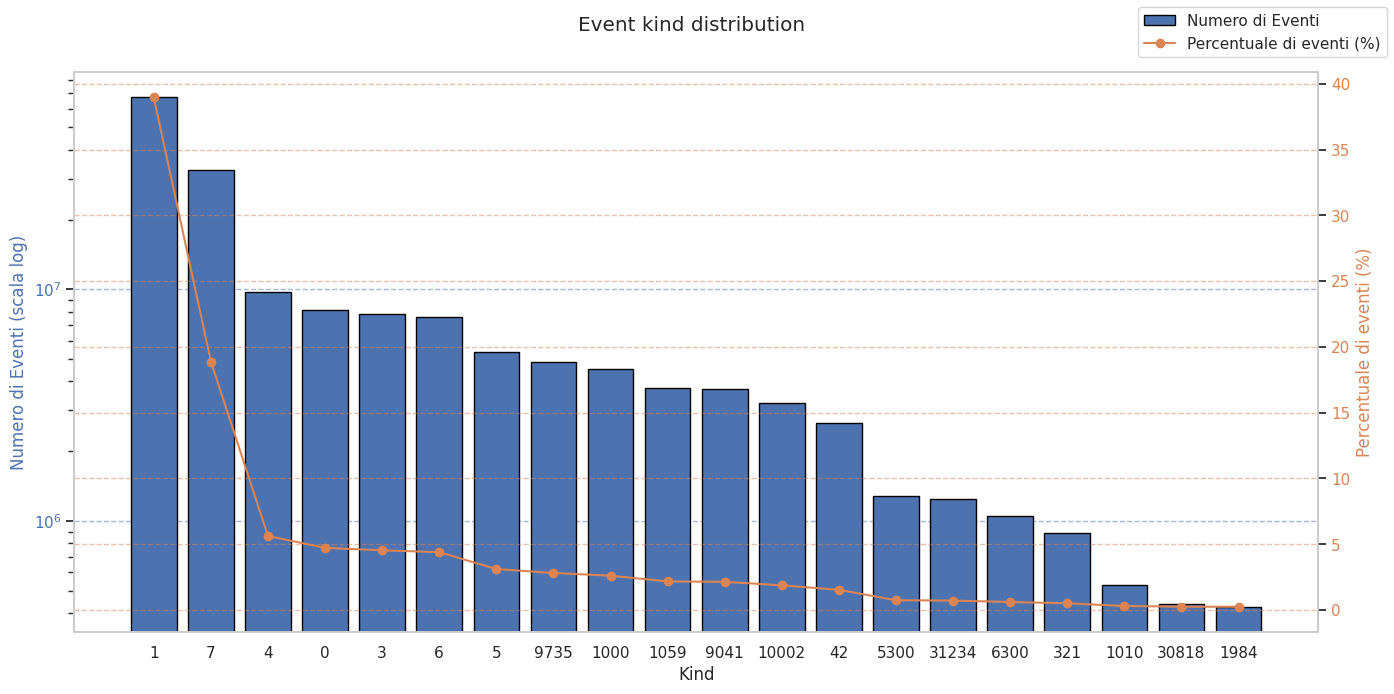

In [6]:
# Selezione dei primi 20 valori
df_plot = kind_counts.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Eventi', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Eventi (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # Rendi trasparente lo sfondo per non coprire le barre

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di eventi (%)', zorder=3)
ax2.set_ylabel('Percentuale di eventi (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind distribution')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [7]:
kind_share = events.unique(subset=["kind", "pubkey"])
kind_share = kind_share.select(
    pl.col("kind").value_counts()
)
kind_share = pd.DataFrame(kind_share.to_pandas())
kind_share['count'] = kind_share['kind'].apply(lambda x: x['count'])
kind_share['kind'] = kind_share['kind'].apply(lambda x: x['kind'])
kind_share = kind_share.sort_values('count', ascending=False).reset_index(drop=True)
kind_share['perc'] = kind_share['count'] / kind_share['count'].sum() * 100

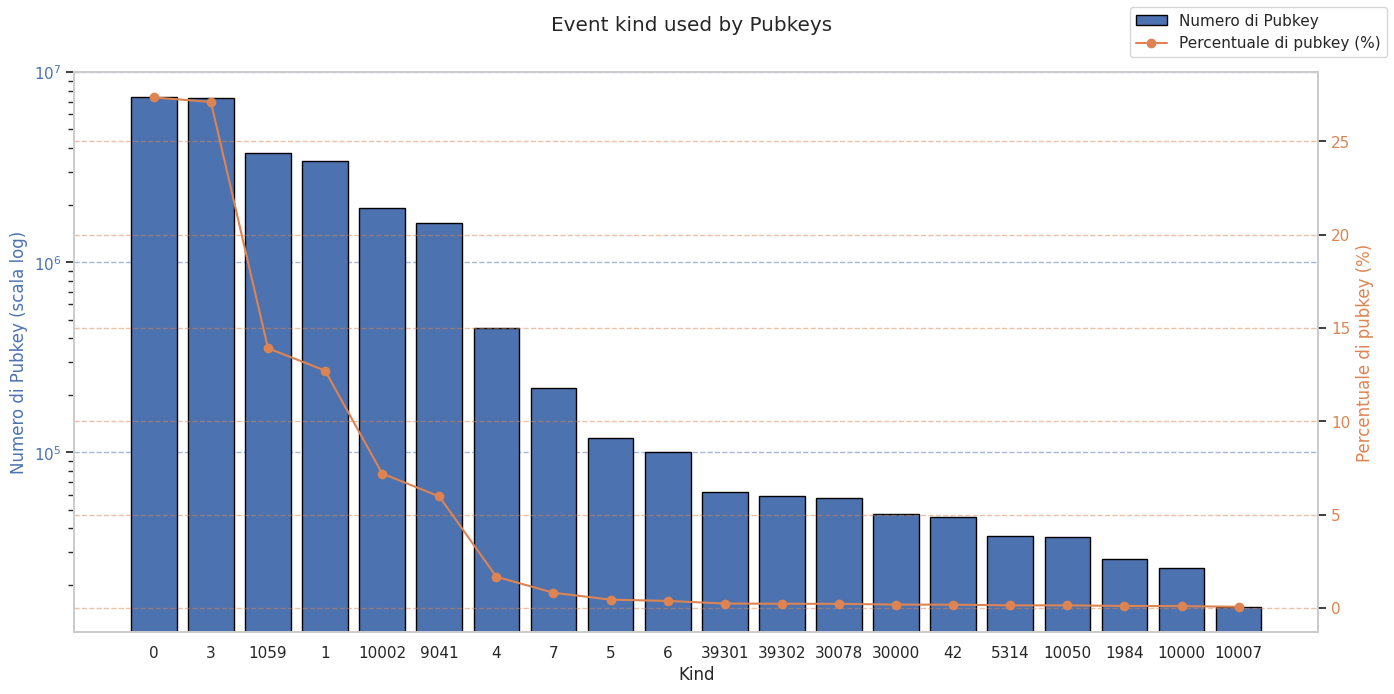

In [8]:
# Selezione dei primi 20 valori
df_plot = kind_share.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Pubkey', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Pubkey (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # sfondo trasparente

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di pubkey (%)', zorder=3)
ax2.set_ylabel('Percentuale di pubkey (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind used by Pubkeys')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [9]:
merged = kind_share.merge(kind_counts, on='kind', suffixes=('_pubkey', '_event'))

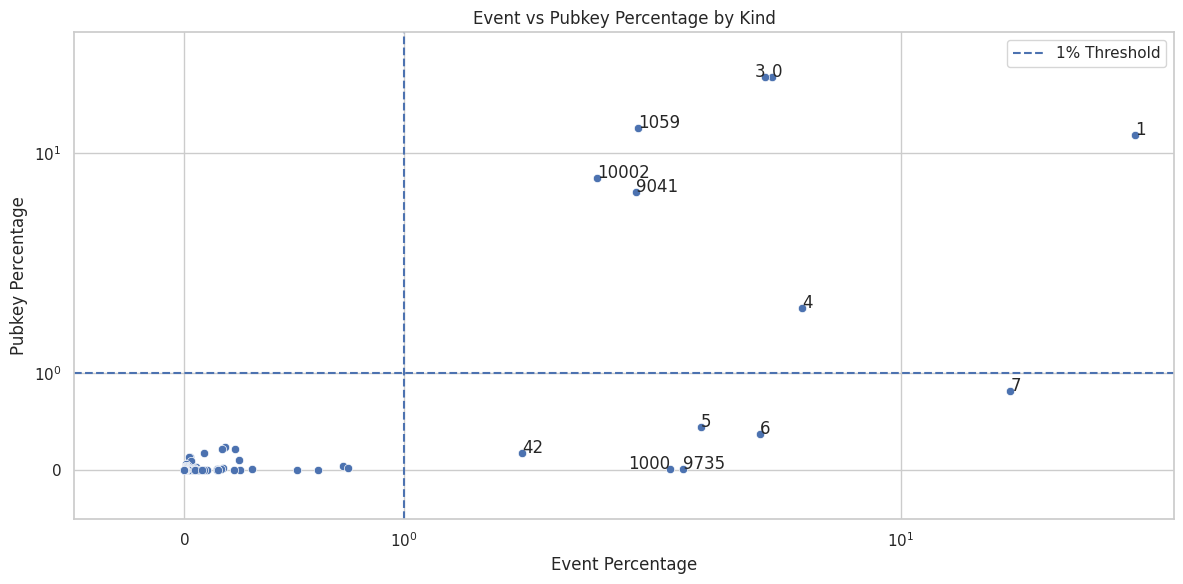

In [10]:
plt.figure()

sns.scatterplot(
    data=merged,
    x='perc_event',
    y='perc_pubkey',
)

plt.xlabel('Event Percentage')
plt.ylabel('Pubkey Percentage')
plt.title('Event vs Pubkey Percentage by Kind')
plt.xscale('symlog')
plt.yscale('symlog')
plt.tight_layout()

min_val = min(merged['perc_event'].min(), merged['perc_pubkey'].min())
max_val = max(merged['perc_event'].max(), merged['perc_pubkey'].max())

# Imposta gli stessi limiti per entrambi gli assi
plt.xlim(min_val-0.5, max_val+10)
plt.ylim(min_val-0.5, max_val+10)

# add label per ogni punto solo se il valore è maggiore di 0.1
for i in range(len(merged)):
    if merged['perc_event'].iloc[i] >= 1 or merged['perc_pubkey'].iloc[i] >= 1:
        if merged['kind'].iloc[i] not in [3, 1000]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='left',
                va='baseline',
            )
        else:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='right',
                va='baseline',
            )
plt.axhline(y=1, linestyle='--', label='1% Threshold')
plt.axvline(x=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
bigbrotr.close()